# Segmentation evaluation (validation)

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import argparse
import itertools
import os, sys
import pickle, shutil
from datetime import datetime
from pathlib import Path

import PIL, cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
import IIC.archs as archs
from IIC.utils.cluster.general import config_to_str, get_opt, update_lr, nice
from IIC.utils.cluster.transforms import sobel_process
from IIC.utils.segmentation.segmentation_eval import segmentation_eval
from IIC.utils.segmentation.IID_losses import (IID_segmentation_loss, 
                                               IID_segmentation_loss_uncollapsed)
from IIC.utils.segmentation.data import segmentation_create_dataloaders
from IIC.utils.segmentation.general import set_segmentation_input_channels
from IIC.datasets.segmentation.potsdam import Potsdam

In [4]:
def _cp(src, dst):
    assert src.is_file()
    shutil.copy(src, dst)
    
Path.cp = _cp
Path.ls = lambda o: list(o.iterdir())

## Config

The following run taken from `examples/commands.txt` for a semi-supervised over-clustering segmentation of the Potsdam-3 dataset will be looked at here.

```
Potsdam-3 (482)
export CUDA_VISIBLE_DEVICES=2,3 && nohup python -m code.scripts.segmentation.segmentation --mode IID+ --dataset Potsdam --dataset_root /scratch/local/ssd/xuji/POTSDAM --model_ind 482 --arch SegmentationNet10a --num_epochs 4800 --lr 0.00001 --lamb 1.0 --num_sub_heads 1 --batch_sz 75 --num_dataloaders 1 --use_coarse_labels --output_k 9 --gt_k 3 --input_sz 200 --half_T_side_sparse_min 0 --half_T_side_sparse_max 0 --half_T_side_dense 10 --include_rgb --no_sobel --jitter_brightness 0.1 --jitter_contrast 0.1 --jitter_saturation 0.1 --jitter_hue 0.1 --use_uncollapsed_loss --batchnorm_track > sh13_gpu23_m482_r1.out &
```

In [5]:
class Config:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_ind = 482            # type=int, required=True
    arch = 'SegmentationNet10a'# type=str, required=True
    opt = 'Adam'   
    mode = 'IID+'  
    dataset = 'Potsdam'        # type=str, required=True
    dataset_root = '/scratch/local/ssd/xuji/POTSDAM'  # type=str, required=True
    use_coarse_labels = False  # default=False, action="store_true")  # COCO, Potsdam
    fine_to_coarse_dict = ("/users/xuji/iid/iid_private/code/datasets"
                           "/segmentation/util/out/fine_to_coarse_dict.pickle")
    include_things_labels = False 
    incl_animal_things = False 
    coco_164k_curated_version = -1
    gt_k = 3                   # type=int, required=True
    output_k = 9               # type=int, required=True
    lamb = 1.0  
    lr = 0.01
    lr_schedule = []
    lr_mult = .1
    use_uncollapsed_loss = False
    mask_input = False
    num_epochs = 1000
    batch_sz = 75 # type=int, required=True  # num pairs
    num_dataloaders = 3
    num_sub_heads = 5
    out_root = "iid_private"
    restart = False
    save_freq = 5 
    test_code = False 
    batchnorm_track = False 
    # data transforms
    no_sobel = False 
    include_rgb = False
    pre_scale_all = False
    pre_scale_factor = .5
    use_random_scale = False
    scale_min = 6. 
    scale_max = 1.4 
    input_sz = 161 
    # transforms we learn invariance to
    jitter_brightness = .4
    jitter_contrast = .4 
    jitter_saturation = 0.4
    jitter_hue = 0.125
    flip_p = 0.5

    use_random_affine = False
    aff_min_rot = -30. # degrees
    aff_max_rot = 30.  # degrees
    aff_min_shear = -10.  # degrees
    aff_max_shear = 10.  # degrees
    aff_min_scale = 0.8
    aff_max_scale = 1.2

# local spatial invariance. Dense means done convolutionally. Sparse means done
#  once in data augmentation phase. These are not mutually exclusive
    half_T_side_dense = 0
    half_T_side_sparse_min = 0
    half_T_side_sparse_max = 0

In [6]:
config = Config()

Set the parameters values according to the command given above.

In [7]:
config.mode = 'IID+'
config.dataset = 'Potsdam'
config.dataset_root = '/Users/jack/git_repos/IIC/datasets/POTSDAM/'
config.model_ind = 482
config.arch = 'SegmentationNet10a'
config.num_epochs = 4800
config.lr = 0.00001
config.lamb = 1.0
config.num_sub_heads = 1
config.batch_sz = 32
config.num_dataloaders = 1
config.use_coarse_labels = True
config.output_k = 9 
config.gt_k = 3 
config.input_sz = 200
config.half_T_side_sparse_min = 0 
config.half_T_side_sparse_max = 0 
config.half_T_side_dense = 10
config.include_rgb = True
config.no_sobel = True
config.jitter_brightness = 0.1 
config.jitter_contrast = 0.1 
config.jitter_saturation = 0.1 
config.jitter_hue = 0.1
config.use_uncollapsed_loss = True
config.batchnorm_track = True

### Further setup

In [8]:
config.out_dir = os.path.join(config.out_root, str(config.model_ind))
config.dataloader_batch_sz = int(config.batch_sz / config.num_dataloaders)
assert (config.mode == "IID+")
assert (config.output_k >= config.gt_k)
assert (not (config.no_sobel and (not config.include_rgb)))
config.eval_mode = "orig"
config.use_doersch_datasets = False
set_segmentation_input_channels(config)

if not os.path.exists(config.out_dir):
    os.makedirs(config.out_dir)
    
if config.restart:
    config_name = "config.pickle"
    dict_name = "latest.pytorch"

    given_config = config
    reloaded_config_path = os.path.join(given_config.out_dir, config_name)
    print("Loading restarting config from: %s" % reloaded_config_path)
    with open(reloaded_config_path, "rb") as config_f:
        config = pickle.load(config_f)
    assert (config.model_ind == given_config.model_ind)
    config.restart = True

    # copy over new num_epochs and lr schedule
    config.num_epochs = given_config.num_epochs
    config.lr_schedule = given_config.lr_schedule
else:
    print("Given config: %s" % config_to_str(config))

Given config: Config: -----
mode: IID+
dataset: Potsdam
dataset_root: /Users/jack/git_repos/IIC/datasets/POTSDAM/
model_ind: 482
arch: SegmentationNet10a
num_epochs: 4800
lr: 1e-05
lamb: 1.0
num_sub_heads: 1
batch_sz: 32
num_dataloaders: 1
use_coarse_labels: True
output_k: 9
gt_k: 3
input_sz: 200
half_T_side_sparse_min: 0
half_T_side_sparse_max: 0
half_T_side_dense: 10
include_rgb: True
no_sobel: True
jitter_brightness: 0.1
jitter_contrast: 0.1
jitter_saturation: 0.1
jitter_hue: 0.1
use_uncollapsed_loss: True
batchnorm_track: True
out_dir: iid_private/482
dataloader_batch_sz: 32
eval_mode: orig
use_doersch_datasets: False
in_channels: 4
using_IR: True
----------


## Data

In [9]:
dataloaders, mapping_assignment_dataloader, mapping_test_dataloader = \
segmentation_create_dataloaders(config)

Creating paired dataloader 0 out of 1 time 2020-09-18 07:45:12.055706
Length of paired datasets vector 1
Number of batches per epoch: 241


### Quick look at a batch

In [10]:
img1, img2, tfm, mask = next(iter(dataloaders[0]))

In [11]:
img1.shape, img2.shape, tfm.shape, mask.shape

(torch.Size([32, 4, 200, 200]),
 torch.Size([32, 4, 200, 200]),
 torch.Size([32, 2, 3]),
 torch.Size([32, 200, 200]))

In [12]:
img1 = img1.cpu()
img2 = img2.cpu()
tfm = tfm.cpu()
mask = mask.cpu()

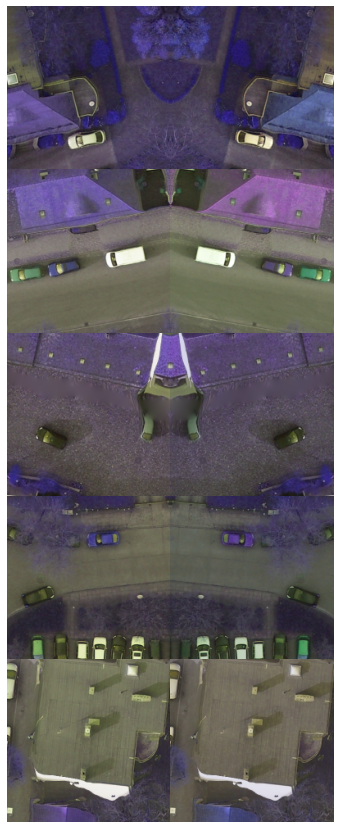

In [13]:
n = 5
ncols = 2
nrows = 5
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(ncols*3, nrows*3))
for row, im1, im2 in zip(axs, img1[11:11+n], img2[11:11+n]):
    for ax in row: ax.axis('off')
    im1 = im1[1:4].permute(1, 2, 0).numpy()
    im2 = im2[1:4].permute(1, 2, 0).numpy()
    row[0].imshow(im1)
    row[1].imshow(im2)
    
fig.subplots_adjust(hspace=0, wspace=-.05)

In [14]:
del img1, img2, tfm, mask

## Model

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
config.arch

'SegmentationNet10a'

In [17]:
from IIC.archs.segmentation.net10a import SegmentationNet10a

In [18]:
model = SegmentationNet10a(config)

In [19]:
next(model.trunk.parameters())[0].device

device(type='cpu')

In [20]:
if config.restart:
    d_cpt = torch.load(os.path.join(config.out_dir, dict_name),
                           map_location=lambda storage, loc: storage)
    model.load_state_dict(d_cpt["net"])    

In [21]:
model.to(device);

In [22]:
model = torch.nn.DataParallel(model)
model.train();

In [23]:
next(model.module.trunk.parameters()).device

device(type='cpu')

In [24]:
! nvidia-smi

/bin/bash: nvidia-smi: command not found


## Optimiser

In [25]:
optimiser = get_opt(config.opt)(model.module.parameters(), lr=config.lr)

In [26]:
if config.restart:
    optimiser.load_state_dict(d_cpt['opt'])

## `_segmentation_get_data()`
`IIC.utils.segmentation.segmentation_eval._segmentation_get_data(config, net, dataloader, sobel=False, using_IR=False, verbose=0)`

This function loads mini-batches that are for validation, pass the images through the model, returns the predictions along with the targets.

In [27]:
net = model
dataloader = mapping_assignment_dataloader
sobel = not config.no_sobel
using_IR = config.using_IR
verbose = 1

In [28]:
assert config.output_k <= 255

In [96]:
num_batches = len(dataloader)
num_samples = 0

In [97]:
samples_per_batch = config.batch_sz * config.input_sz**2

In [98]:
samples_per_batch

1280000

In [99]:
if verbose > 0:
    print(f'Started _segmentation_get_data {datetime.now()}')

Started _segmentation_get_data 2020-09-18 09:57:59.741744


In [100]:
flat_predss_all = [torch.zeros(
    (num_batches * samples_per_batch), dtype=torch.uint8).to(device) 
                   for _ in range(config.num_sub_heads)]
flat_targets_all = torch.zeros(
    (num_batches * samples_per_batch), dtype=torch.uint8).to(device)
mask_all = torch.zeros(
    (num_batches * samples_per_batch), dtype=torch.uint8).to(device)

In [101]:
flat_predss_all, flat_predss_all[0].shape

([tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)],
 torch.Size([183040000]))

In [102]:
if verbose > 0:
    batch_start = datetime.now()
    all_start = batch_start
    print(f'Starting batches {all_start}')

Starting batches 2020-09-18 09:58:03.296758


In [126]:
for b_i, batch in enumerate(dataloader):
    if b_i == 1: break

In [127]:
type(batch), len(batch)

(list, 3)

In [128]:
print('\r', f'batch {b_i}', end='')

 batch 1

In [129]:
imgs, flat_targets, mask = batch

In [130]:
imgs.shape

torch.Size([32, 4, 200, 200])

In [131]:
flat_targets.shape, flat_targets.unique()

(torch.Size([32, 200, 200]), tensor([0, 1, 2], dtype=torch.int32))

In [132]:
mask.shape, mask.unique()

(torch.Size([32, 200, 200]), tensor([1], dtype=torch.uint8))

In [133]:
imgs = imgs.to(device)

In [134]:
if sobel:
    imgs = sobel_process(imgs, config.include_rgb, using_IR=using_IR)

In [135]:
net.eval();

In [136]:
%%time
with torch.no_grad(): x_outs = net(imgs)

CPU times: user 40 s, sys: 2.96 s, total: 43 s
Wall time: 30.5 s


In [137]:
x_outs[0].shape[1:] == (config.output_k, config.input_sz, config.input_sz)

True

In [138]:
actual_samples_curr = flat_targets.view(-1).shape[0]
num_samples += actual_samples_curr

In [139]:
start_i = b_i * samples_per_batch

In [140]:
start_i

1280000

In [141]:
config.num_sub_heads, len(x_outs)

(1, 1)

In [142]:
i = 0  # there's only 1 subhead

In [143]:
x_outs_curr = x_outs[i]
assert x_outs_curr.requires_grad is False

In [144]:
flat_preds_curr = torch.argmax(x_outs_curr, dim=1)

In [145]:
flat_predss_all[i][
    start_i:start_i + actual_samples_curr] = flat_preds_curr.view(-1)

In [146]:
# Out of loop over subheads

In [147]:
flat_targets_all[
    start_i:start_i + actual_samples_curr] = flat_targets.view(-1)
mask_all[start_i:start_i + actual_samples_curr] = mask.view(-1)

In [148]:
if verbose>0 and b_i<3:
    batch_finish = datetime.now()
    print(f'finished batch {b_i} {batch_finish} '
          f'{batch_finish - batch_start} {num_batches}')
    batch_start = batch_finish

finished batch 1 2020-09-18 10:05:23.137006 0:06:05.037777 143


In [149]:
# Out of loop over mini-batches

In [150]:
if verbose > 0:
    all_finish = datetime.now()
    print(f'finished all batches {all_finish}, ' 
          f'took {all_finish - all_start}')

finished all batches 2020-09-18 10:05:26.214021, took 0:07:22.917263


In [151]:
flat_predss_all = [
    flat_predss_all[i][:num_samples] for i in range(config.num_sub_heads)]
flat_targets_all = flat_targets_all[:num_samples]
mask_all = mask_all[:num_samples]

In [152]:
if verbose > 0:
    print(f'ended _segmentation_get_data {datetime.now()}')

ended _segmentation_get_data 2020-09-18 10:05:33.332129


In [153]:
selected_samples = mask_all.sum()

In [154]:
selected_samples

tensor(2560000)

In [156]:
assert flat_predss_all[0].shape == (selected_samples,)
assert flat_targets_all.shape == (selected_samples,)

In [158]:
flat_predss_all, flat_targets_all

([tensor([8, 8, 8,  ..., 8, 8, 8], dtype=torch.uint8)],
 tensor([2, 2, 2,  ..., 2, 2, 2], dtype=torch.uint8))

## `_original_match()`
`IIC.utils.cluster.eval_metrics._original_match(flat_preds, flat_targets, preds_k, targets_k)`

In [165]:
flat_preds = flat_predss_all[0]
flat_targets = flat_targets_all
preds_k = config.output_k
targets_k = config.gt_k

`flat_preds` are the predicted masks of all the images, rolled out into a vector.  Each element in it corresponds to a pixel location in the predicted mask over some image.  There are `preds_k` prediction classes; 9 here.  The predicted pixels, `flat_preds`, are divided amongst these prediction classes. 

`flat_targets` are the ground truth masks of all the images, rolled out into a vector.  Each element in it corresponds to a pixel location in the ground truth mask over some image.  There are `targets_k` target classes: (0) roads and cars, (1) buildings and clutter, and (2) vegetation and trees.  The target pixels, `targets_k`, are divided amongst these target classes. 

In [176]:
assert (isinstance(flat_preds, torch.Tensor) and
        isinstance(flat_targets, torch.Tensor) and
        flat_preds.is_cuda and targets_k.is_cuda)

AssertionError: 

Take an image as example.

In [248]:
sz = config.input_sz

In [304]:
i_img = 8

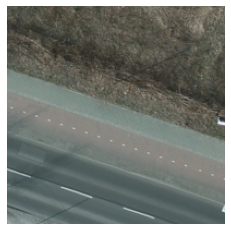

In [305]:
img, _, _ = dataloader.dataset[i_img]
plt.imshow(img[:3,...].permute(1, 2, 0).numpy())
plt.axis('off');

In [308]:
def get_mask(flat, i_img=0, c=0, sz=200):
    '''
    Return boolean mask over image `i_img`, 
    where `True` indicates where class in `flat` is equal to `c`.
    Image size is `sz`.
    '''
    flat_img = flat[i_img*sz**2:(i_img + 1)*sz**2]
    return (flat_img==c).view(sz, sz).numpy()

The prediction for the image is a mask with pixel values from 0 to `preds_k - 1` (0 to 8 here).  It can also be represented by `preds_k` binary masks (with pixel values of either 0 or 1), one for each prediction class.

It can be seen, for this example (`i_img` = 11), that most pixels are predicted to belong to either prediction class 3 or 5.

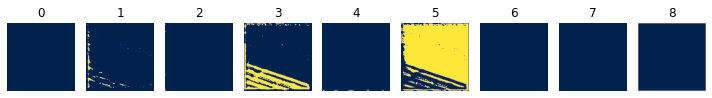

In [310]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=1, ncols=preds_k)
axs = axs.flatten()
for ax, out_c in zip(axs, range(preds_k)):
    mask_pred = get_mask(flat_preds, i_img, c=out_c, sz=config.input_sz)
    ax.imshow(mask_pred, cmap='cividis')
    ax.set_title(f'{out_c}')
    ax.axis('off')
plt.tight_layout()

Similarly, the ground truth for the image is a mask with pixel values from 0 to `targets_k` (0 to 2 here).  It can also be represented by `targets_k` binary masks (with pixel values of either 0 or 1), one for each ground truth (or target) class.

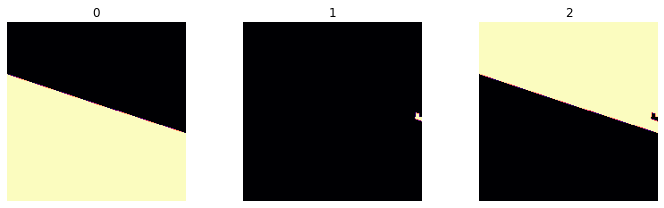

In [311]:
fig, axs = plt.subplots(figsize=(10, 3), nrows=1, ncols=targets_k)
axs = axs.flatten()
for ax, gt_c in zip(axs, range(targets_k)):
    mask_targ = get_mask(flat_targets, i_img, c=gt_c, sz=config.input_sz)
    ax.imshow(mask_targ, cmap='magma')
    ax.set_title(f'{gt_c}')
    ax.axis('off')
plt.tight_layout()

In the current example (`i_img=11`), by comparing the predicted binary masks with the target binary masks, it's seen that out of the 9 predicated classes, prediction class 3 corresponds most closely to the target class 0, given the location and shape of its overall spread.  Prediction class 5 appears to correspond most closely to the target class 2.  The whole image appears to be more or less completely covered by these two classes.  

But it's also seen that the prediction is far from good.  The line separating these two major classes is at a different height between the prediction and the ground truth; it's higher in the ground truth.  Hence, the overlap is between the prediction and the ground truth for these two classes is not great. 

In [315]:
import pandas as pd

More generally, the overlap between each pair of predicted class and target class can be computed.  This measures how well the predicted class and the target class correspond to each other.  The higher it is, the better the correspondence.  

The overlap is the elementwise product between binary masks, summed.  Note that this is different from the result of the `==` operator, summed.  This is because only the postivie predictions (the 1s) in the binary masks are of interest.

In the table below is shown this overlap between all pairs of prediction class and target class.

Even though, by manual examination, target class 0 and prediction class 3 appear to correspond to the same class, which covers the bottom left corner of the image, because the prediction is off, the prediction class 5 actually has a larger overlap with target class 0 than prediction class 3.  Further training of the model should tilt this the other way.

In [320]:
df = pd.DataFrame(index=range(targets_k), columns=range(preds_k))
df.index.name = 'target class'
df.columns.name = 'prediction class'

for out_c in range(preds_k):
    for gt_c in range(targets_k):
        mask_pred = get_mask(flat_preds, i_img, c=out_c, sz=config.input_sz)
        mask_targ = get_mask(flat_targets, i_img, c=gt_c, sz=config.input_sz)
        overlap = (mask_pred * mask_targ).sum()
        df.loc[gt_c, out_c] = overlap
df

prediction class,0,1,2,3,4,5,6,7,8
target class,,,,,,,,,
0,0,768,12,6874,91,13574,0,0,416
1,0,0,0,0,0,40,0,0,5
2,0,79,6,478,0,17282,0,0,375


In [218]:
for out_c in range(preds_k)[:4]:
    for gt_c in range(targets_k):
        print(out_c, gt_c, 
              ((flat_preds==out_c) * (flat_targets==gt_c)).sum())

0 0 tensor(20)
0 1 tensor(0)
0 2 tensor(0)
1 0 tensor(25621)
1 1 tensor(22296)
1 2 tensor(16511)
2 0 tensor(237)
2 1 tensor(341)
2 2 tensor(156)
3 0 tensor(225222)
3 1 tensor(175764)
3 2 tensor(64760)


## `_get_assignment_data_matches()`

`IIC.utils.cluster.cluster_eval._get_assignment_data_matches(net, mapping_assignment_dataloader, config,                                  sobel=False, using_IR=False, just_matches=False, verbose=0)`

Get all best matches per head based on train set i.e. mapping_assign,
  and mapping_assign accs.

In [163]:
num_test = len(flat_targets_all)

In [164]:
config.eval_mode

'orig'

In [38]:
_ = segmentation_eval(
    config, model, 
    mapping_assignment_dataloader=mapping_assignment_dataloader,
    mapping_test_dataloader=mapping_test_dataloader,
    sobel=config.no_sobel is False,
    using_IR=config.using_IR)
print(f"Pre: time {datetime.now():s}: \n"
      f"{nice(config.epoch_stats[-1]):s}")
sys.stdout.flush()
next_epoch = 1

batch 0

KeyboardInterrupt: 

# Reference

- [Invariant Information Clustering for Unsupervised Image Classification and Segmentation](https://arxiv.org/pdf/1807.06653.pdf)